# UNFINISHED

In [98]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import time
import sys
import matplotlib.pyplot as plt
import math
import os
from sklearn.cluster import MiniBatchKMeans
import seaborn as sns
import scanpy as sc
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Correlation analysis from CellAtlas_percent notebook

## User input

In [99]:
# Shannon diversity
# Set filepaths 
input_filepath = "/Users/timnoahkempchen/Library/CloudStorage/GoogleDrive-timkem@stanford.edu/Meine Ablage/Datasets/data/22_08_09_CellAtlas_only_Processed_Metadata.csv"
output_filepath = "/Users/timnoahkempchen/Downloads/Output_test"
save_path = output_filepath
# mandatory 
## define column that defines replicates 
rep ='unique_region'

## specify column used to group the data 
group_com = 'community' # order can specify the order in which group_com is plotted on the x axis 
# used by helper function 
## a column name from the input dataframe, defines the category for which the percentage will be calculated
per_categ = 'Cell Type' 
## a column name from the input dataframe, defines a subset of the data to use
sub_column = 'Major Cell Cat'
## define string which is used to subset sub_column  
sub_l = ['Immune','Epithelial','Mesenchymal']

# optional
## Set specific colors for figure 
coloring = None
## Specify order for x axis 
ordering = None 
## Save figure - boolean 
save = True
## change figure size 
fig_size=8


## Load data

In [101]:
df = pd.read_csv(input_filepath, index_col=0)
df.columns

KeyboardInterrupt: 

## Functions

In [ ]:
def cor_subset(cor_mat, threshold, cell_type):
    pairs = get_top_abs_correlations(cor_mat,thresh=threshold)
    
    piar1 = pairs.loc[pairs['col1']==cell_type]
    piar2 = pairs.loc[pairs['col2']==cell_type]
    piar=pd.concat([piar1,piar2])
    
    pair_list = list(set(list(piar['col1'].unique())+list(piar['col2'].unique())))
    
    return pair_list, piar, pairs

"""
mp: A pandas dataframe from which a subset of columns will be selected and plotted.
sub_list: A list of column names from the dataframe mp that will be selected and plotted.
save_name (optional): A string that specifies the file name for saving the plot. 
If save_name is not provided, the plot will not be saved.
"""
def cor_subplot(mp, sub_list,save_name=None):
    sub_cor = mp[sub_list]
    sns.pairplot(sub_cor,diag_kind = 'kde',
                             plot_kws = {'scatter_kws':{'alpha': 0.6, 's': 80, 'edgecolor': 'k'}},
                             size = 4, kind='reg', corner=True)
    if save_name:
        plt.savefig(output_filepath+save_name+'_corrplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')


"""
data: the input pandas data frame.
sub_l2: a list of subcategories to be considered.
per_categ: the categorical column in the data frame to be used.
group2: the grouping column in the data frame.
repl: the replicate column in the data frame.
sub_collumn: the subcategory column in the data frame.
cell: the cell type column in the data frame.
thres (optional): the threshold for the correlation, default is 0.9.
normed (optional): if the percentage should be normalized, default is True.
cell2 (optional): the second cell type column in the data frame.
"""
def corr_cell(data,  sub_l2, per_categ, group2, repl, sub_collumn, cell,\
              thres = 0.9, normed=True, cell2=None):
    result = per_only1(data = df, per_cat = per_categ, grouping=group2,\
                      sub_list=sub_l2, replicate=repl, sub_col = sub_collumn, norm=normed)

    #Format for correlation function
    mp = pd.pivot_table(result, columns = [per_categ], index=[group2,repl], values=['percentage'])
    mp.columns = mp.columns.droplevel(0)
    cc = mp.reset_index()
    cmat = cc.corr()

    #Plot
    sl2, pair2, all_pairs = cor_subset(cor_mat=cmat, threshold = thres, cell_type=cell)
    
    if cell2:
        sl3 = [cell2, cell]
        cor_subplot(mp=cc, sub_list=sl3, save_name=cell+'_'+cell2)
    else:
        cor_subplot(mp=cc, sub_list=sl2, save_name=cell)
    
    return all_pairs, pair2


## Helper functions 

In [ ]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, thresh=0.5):
    au_corr = df.corr().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    cc = au_corr.to_frame()
    cc.index.rename(['col1','col2'],inplace=True)
    cc.reset_index(inplace=True)
    cc.rename(columns={0:'value'},inplace=True)
    gt_pair = cc.loc[cc['value'].abs().gt(thresh)]
    return gt_pair

def per_only1(data, grouping, replicate,sub_col, sub_list, per_cat, norm=True):
    
    #Find Percentage of cell type
    if norm==True:
        test1 = data.loc[data[sub_col].isin(sub_list)] #filters df for values by values in sub_list which are in the sub_col column 
        immune_list = list(test1[per_cat].unique()) #stores unique values for the per_cat column 
    else:
        test1=data.copy()
        immune_list = list(data.loc[data[sub_col].isin(sub_list)][per_cat].unique())
    
    test1[per_cat] = test1[per_cat].astype('category')
    test_freq = test1.groupby([grouping,replicate]).apply(lambda x: x[per_cat].value_counts(normalize = True,sort = False)*100) #group data by grouping variable and replicates, than applies the lambda function to count the frequency of each category in the per_cat column and normalizes by dividing by the total count.
    test_freq.columns = test_freq.columns.astype(str)
    test_freq.reset_index(inplace=True)
    immune_list.extend([grouping,replicate]) #adds grouping and replicate column to immune_list 
    test_freq1 = test_freq[immune_list] # subsets test_freq by immune_list

    melt_per_plot = pd.melt(test_freq1, id_vars=[grouping,replicate])#,value_vars=immune_list) #converts columns specified in id_vars into rows
    melt_per_plot.rename(columns={'value': 'percentage'}, inplace=True) #rename value to percentage 
    
    return melt_per_plot # returns a df which contains the group_column followed by the replicate column and the per category column, and a column specifying the percentage
    # Example: percentage CD4+ TCs in unique region E08 assigned to community xxx

/var/folders/6d/0x48qjh15rx9851lpdwvrxvc0000gn/T/ipykernel_44358/2686583481.py:42: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cmat = cc.corr()
/Users/timnoahkempchen/opt/anaconda3/envs/spatial_analysis_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


,col1,col2,value
0,Foveloar p53+,Goblet p53+,0.999957
1,Epithelial CK7+,Goblet p53+,0.999746
2,Goblet Ki67+ p53+,Paneth,0.999712
3,Epithelial CK7+,Foveloar p53+,0.999606
4,Foveloar p53+,Goblet Ki67+ p53+,0.997690
...,...,...,...
56,Chief,Lymphatic CD73+,0.705547
57,Lymphatic CD73+,M2 Macrophage,0.704941
58,M2 Macrophage,Stroma CD73+,0.704066
59,CD4+ Treg,Epithelial Ki67+ p53+,0.700587


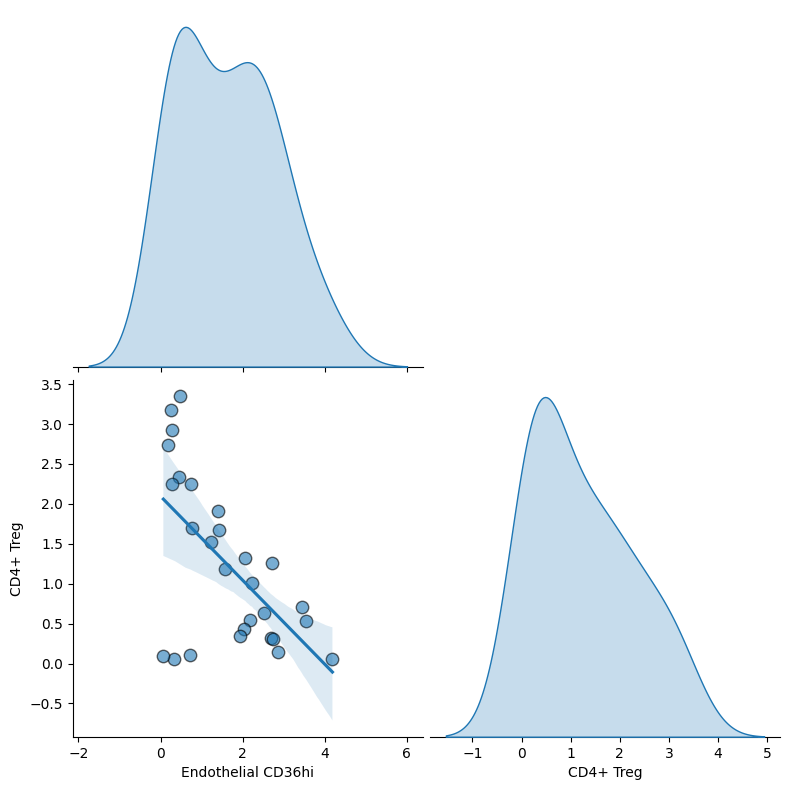

In [161]:
sub_l = ['Immune','Epithelial','Mesenchymal']
all_pair, sub_pari = corr_cell(data=df,  sub_l2=sub_l, per_categ='Cell Type', group2='Sub diagnosis', \
                               repl='unique_region',  sub_collumn= 'Major Cell Cat', cell='CD4+ Treg',\
                               normed=True, thres=0.7, cell2 = 'Endothelial CD36hi')
all_pair

In [ ]:
cell_type = ['CD4+ Treg', "B cell"]
piar = all_pair.loc[all_pair['col1'].isin(cell_type)]
piar

,col1,col2,value
36,B cell,CD4+ T cell,0.799635
37,CD4+ Treg,DC,0.792409
41,CD4+ Treg,Neutrophil,0.756654
45,CD4+ Treg,Endothelial,0.744855
59,CD4+ Treg,Epithelial Ki67+ p53+,0.700587
989,CD4+ Treg,Endothelial CD36hi,-0.762162


In [153]:
cell_type = "CD4+ T cell"
piar1 = all_pair.loc[all_pair['col1']==cell_type]
piar2 = all_pair.loc[all_pair['col2']==cell_type]
piar=pd.concat([piar1,piar2])
piar

,col1,col2,value
36,B cell,CD4+ T cell,0.799635


In [154]:
pair_list = list(set(list(piar['col1'].unique())+list(piar['col2'].unique())))
pair_list

['B cell', 'CD4+ T cell']

In [162]:

mp=all_pair.pivot_table(index='col2', columns='col1', values='value', dropna=False)
print(mp.columns)

Index(['B cell', 'CD4+ Treg', 'CD8+ T cell', 'CD8+ T cell PD1+', 'Chief', 'DC',
       'Endothelial', 'Endothelial CD36hi', 'Endothelial aSMAhi',
       'Epithelial CD73hi', 'Epithelial CK7+', 'Epithelial CK7+ p53+',
       'Epithelial Ki67+ p53+', 'Epithelial MUC1+ Ki67+', 'Epithelial p53+',
       'Foveloar', 'Foveloar Ki67+ p53+', 'Foveloar p53+', 'Goblet Ki67+ p53+',
       'Goblet p53+', 'Lymphatic', 'Lymphatic CD73+', 'M2 Macrophage', 'Neck',
       'Neck Ki67+ p53+', 'Neck p53+', 'Squamous Annexin A1+'],
      dtype='object', name='col1')


In [185]:
A = mp.columns.values
B = mp.index.values

In [138]:
len(np.intersect1d(A, B))

18

In [156]:
all_pair2 = all_pair.loc[all_pair['col1'].isin(np.intersect1d(A, B)), :]
all_pair2 = all_pair.loc[all_pair['col2'].isin(np.intersect1d(A, B)), :]

In [157]:
mp=all_pair2.pivot_table(index='col2', columns='col1', values='value', dropna=False)
print(mp.columns)

Index(['CD4+ Treg', 'CD8+ T cell', 'CD8+ T cell PD1+', 'Chief', 'DC',
       'Endothelial CD36hi', 'Endothelial aSMAhi', 'Epithelial CD73hi',
       'Epithelial CK7+', 'Epithelial Ki67+ p53+', 'Epithelial p53+',
       'Foveloar', 'Foveloar Ki67+ p53+', 'Foveloar p53+', 'Goblet Ki67+ p53+',
       'Goblet p53+', 'Lymphatic CD73+', 'Neck Ki67+ p53+'],
      dtype='object', name='col1')


In [158]:
mp.shape

(18, 18)

In [159]:
mp.index[1:].isin(mp.columns)

array([ True, False,  True, False,  True,  True,  True,  True,  True,
        True,  True, False,  True, False, False,  True, False])

In [166]:
def cor_subplot(mp, save_name=None):
    sub_cor = mp
    sns.pairplot(sub_cor,diag_kind = 'kde',
                             plot_kws = {'scatter_kws':{'alpha': 0.6, 's': 80, 'edgecolor': 'k'}},
                             size = 4, kind='reg', corner=True)
    if save_name:
        plt.savefig(output_filepath+save_name+'_corrplot.png', format='png', dpi=300, transparent=True, bbox_inches='tight')


In [173]:
A = all_pair['col2'].unique()
B= all_pair['col1'].unique()

In [189]:
print(np.intersect1d(A, B))

pair_list = list(['Chief' 'DC' 'Endothelial' 'Endothelial CD36hi' 'Epithelial CK7+ p53+'
 'Epithelial Ki67+ p53+' 'Epithelial p53+' 'Foveloar'
 'Foveloar Ki67+ p53+' 'Foveloar p53+' 'Goblet Ki67+ p53+' 'Goblet p53+'
 'Lymphatic' 'Lymphatic CD73+' 'M2 Macrophage' 'Neck' 'Neck Ki67+ p53+'
 'Neck p53+'])

['Chief' 'DC' 'Endothelial' 'Endothelial CD36hi' 'Epithelial CK7+ p53+'
 'Epithelial Ki67+ p53+' 'Epithelial p53+' 'Foveloar'
 'Foveloar Ki67+ p53+' 'Foveloar p53+' 'Goblet Ki67+ p53+' 'Goblet p53+'
 'Lymphatic' 'Lymphatic CD73+' 'M2 Macrophage' 'Neck' 'Neck Ki67+ p53+'
 'Neck p53+']


In [169]:
pair_list = list(set(list(all_pair['col1'].unique())+list(all_pair['col2'].unique())))
pair_list

['DC',
 'Neck p53+',
 'Squamous p63+',
 'CD4+ Treg',
 'Foveloar p53+',
 'CD4+ T cell',
 'CD8+ T cell PD1+',
 'Neutrophil',
 'Nerve',
 'Lymphatic CD73+',
 'Epithelial p53+',
 'M2 Macrophage',
 'M1 Macrophage',
 'Foveloar Ki67+ p53+',
 'Goblet',
 'Endothelial',
 'Squamous p63+ EGFRhi',
 'B cell',
 'Paneth',
 'Epithelial CK7+',
 'Lymphatic',
 'Epithelial CD73hi',
 'Stroma CD73+',
 'Epithelial MUC1+ Ki67+',
 'Parietal',
 'Goblet Ki67+ p53+',
 'Neck Ki67+ p53+',
 'Chief',
 'Squamous Annexin A1+',
 'Goblet p53+',
 'Endothelial aSMAhi',
 'Neck',
 'Epithelial CK7+ p53+',
 'CD8+ T cell',
 'Epithelial Ki67+ p53+',
 'Endothelial CD36hi',
 'Foveloar']

In [197]:
pair_list = list(["Epithelial CK7+", "Foveloar Ki67+ p53+", "Foveloar p53+"])

In [198]:
sub_cor = mp[pair_list]

In [199]:
cor_subplot(mp=mp)#, save_name='CK7')

/Users/timnoahkempchen/opt/anaconda3/envs/spatial_analysis_environment/lib/python3.10/site-packages/seaborn/axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


In [164]:
sl = pair_list
cor_subplot(mp=mp, sub_list=sl)#, save_name='CK7')

TypeError: cor_subplot() got an unexpected keyword argument 'sub_list'